# ** Project - Retail Product Categorisation**

## Import the Data from Kaggle

In [51]:
! pip install -q kaggle
from google.colab import files
print("CHoose the kaggel.jason file on your computer")
files.upload() 

CHoose the kaggel.jason file on your computer


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"markusobert","key":"bf8bdd6dd36b298ff3651198bb29ffab"}'}

In [52]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle
# Download of the data from kaggle
! kaggle competitions download -c retail-products-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
retail-products-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [53]:
# Create a directory and unzip the files there
! mkdir retail-products-classification
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null
 

mkdir: cannot create directory ‘retail-products-classification’: File exists


## Importing the necessary libraries

In [54]:
!pip install keras_metrics &> /dev/null
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

#self importeted stuff
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## List of classes
This is the List of the 20 classes in wich the products have to be categorize

In [55]:
CATEGORIES = ['Electronics', 
              'Sports & Outdoors',
              'Cell Phones & Accessories',
              'Automotive', 'Toys & Games',
              'Tools & Home Improvement', 
              'Health & Personal Care', 
              'Beauty',
              'Grocery & Gourmet Food', 
              'Office Products',
              'Arts, Crafts & Sewing',
              'Pet Supplies', 
              'Patio, Lawn & Garden',
              'Clothing, Shoes & Jewelry', 
              'Baby',
              'Musical Instruments',
              'Industrial & Scientific', 
              'Baby Products',
              'Appliances',
              'All Beauty',
              'All Electronics']

## Read the train.csv file 

In [56]:
data = pd.read_csv('retail-products-classification/train.csv')
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


## Distribution of samples in each categories
First have a look how the data is distributed. In this case the data is equally distributed

In [57]:
#data['categories'].value_counts().plot(kind='bar', figsize=(14, 3));
data['categories'].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
All Beauty                   2200
Electronics                  2200
Industrial & Scientific      2200
Baby                         2200
Clothing, Shoes & Jewelry    2200
Automotive                   2200
Appliances                   2200
Pet Supplies                 2200
All Electronics              2200
Toys & Games                 2200
Baby Products                2200
Patio, Lawn & Garden         2200
Musical Instruments          2200
Health & Personal Care       2200
Tools & Home Improvement     2200
Office Products              2200
Cell Phones & Accessories    2200
Name: categories, dtype: int64

##Analyse of the data

### Analyse the number of characters in the title and the description
Have a look at the size of the distribution of the description length. In the Histogramm you can see the most Descriptions have not more than 5000 characters. But there are also some outliers with a lot of more chrachters up to 20000.

Text(0.5, 1.0, 'Characters in the description')

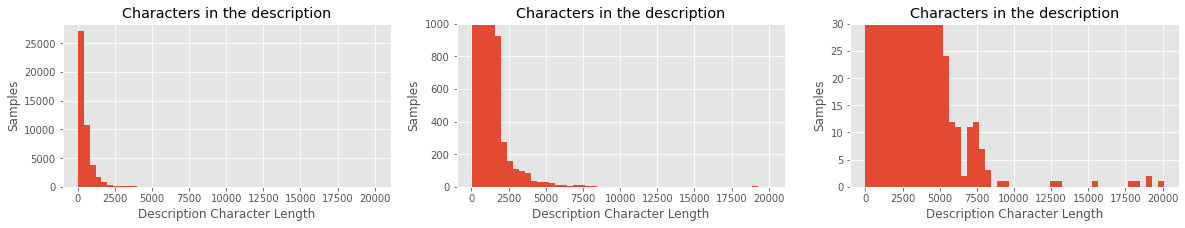

In [58]:
#get the number of characters
char_num=data['description'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the description')

axes[1].hist(char_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the description')

axes[2].hist(char_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the description')

When you have a look at the discription with the most chracters you can see there is alo of thresh in the description. Maybe some html code or something different. So for classifikation we have to drop the tresh of the description.

In [59]:
#Description with the most words
data['description'].iloc[char_num.argmax()]

'Turbo.264 HD Video Encoder &amp; AcceleratorConvert HD video to the universal H.264 formatThe Turbo.264 HD is a USB hardware device and accompanying Mac software that works together to dramatically accelerate the conversion of video to H.264 format.H.264 video is a universal format that can be played on iPod, iPhone, Apple TV, gaming consoles, YouTube, and much more.The Turbo.264 HD accepts nearly any video file and outputs high quality H.264 video, in formats up to full 1080P HD.[if gte mso 9]><xml> <w:WordDocument> <w:View>Normal</w:View> <w:Zoom>0</w:Zoom> <w:TrackMoves  /> <w:TrackFormatting  /> <w:PunctuationKerning  /> <w:ValidateAgainstSchemas  /> <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid> <w:IgnoreMixedContent>false</w:IgnoreMixedContent> <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText> <w:DoNotPromoteQF  /> <w:LidThemeOther>EN-US</w:LidThemeOther> <w:LidThemeAsian>X-NONE</w:LidThemeAsian> <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript> <w:Compati

Also you can see there are 1042 articel without any description (NaN) and one articel with no title.

In [60]:
#count the NaN values
print(data['description'].isnull().sum())
print(data['title'].isnull().sum())
print(data['ImgId'].isnull().sum())
print(data['categories'].isnull().sum())

1042
1
0
0


Later Maybe we can drop the articels without any description but first have look if they are all of a specific categorie. So when we drop all the articels with no description datset of the classesAutomotive and Industrial and Scientific will be reduce by nearly 10 %

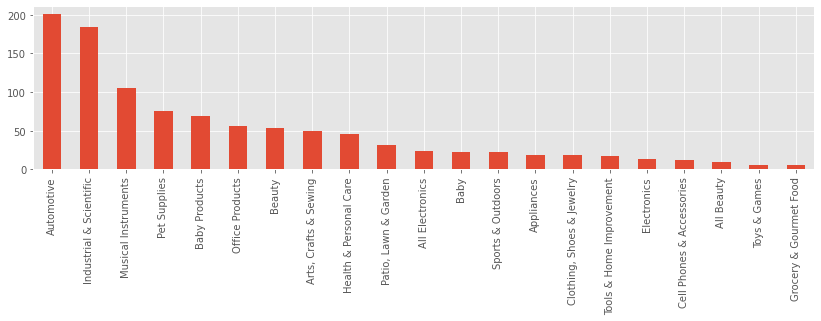

In [61]:
#Distribution of the nan values in the discription in the different categories
#Get the categories of the products where de description is nan
data_nodescrip=data[data['description'].isnull()]
data_nodescrip['categories'].value_counts().plot(kind='bar', figsize=(14, 3));

In [62]:
print(data['description'].iloc[45999])
print(data['title'].iloc[45999])

nan
Swingline LightTouch High Capacity Desktop Punch, 2-3 Holes, 20 Sheets (A7074030)


Text(0.5, 1.0, 'Characters in the title')

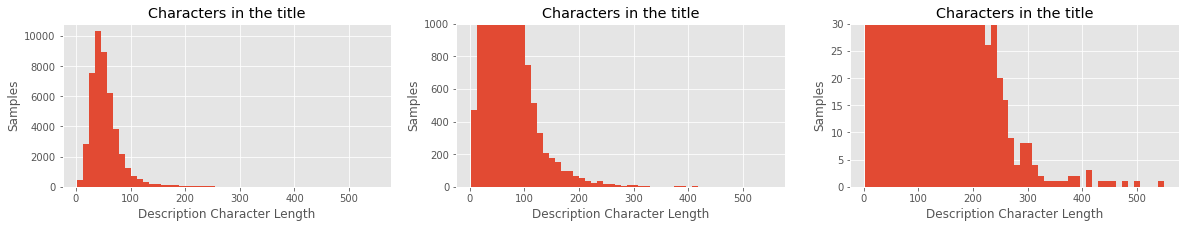

In [63]:
char_num_title=data['title'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the title')

axes[1].hist(char_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the title')

axes[2].hist(char_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the title')

In [64]:
#Title with the most words
data['description'].iloc[char_num_title.argmax()]

'Heavy Duty Luxurious Pashmina Shawl, Wrap And Scarf - Perfect Accessory For Any Seasons, Event or Occasion! You Will Feel So Great Due To This Pashmina Wool is The Finest Cashmere From Inner Mongolia-High Mountain Goat Fur,The Most Soft Wool. All Natural With No Any Imitation or Man Made Materials. Heavy Duty With Soft Touch,Look Fashionable & Stylish , Perfect Size at 27" Width x 70" Length + 3" x 2 Fringe ,Good for Your Wrap ,Shawl and Scarf . A Perfect Item For Christmas Gifts or Birthday Gifts , Super Saving,100% Satisfaction Guaranteed'

In [65]:
#Check for titles with only a few characters in the title
data_short_title=data[data['title'].str.len()<5]
print("Number of titels with less then 5 characters:  ", data_short_title['title'].count())
data_short_title

Number of titels with less then 5 characters:   7


,ImgId,title,description,categories
5591,1934857602,Poo,It&#x2019;s been a tough day in the monkey cag...,Toys & Games
7470,291484980X,Evo,The island of Krah is home to nomadic tribes a...,Toys & Games
20054,B0000T16L8,Rolo,"Two great flavors in one, ROLO candy is made u...",Grocery & Gourmet Food
24275,B00012NBZS,DHEA,"Vitamin Shoppe Dhea, 50 mg, 100 capsules",Health & Personal Care
33614,B0000CA2RD,Zori,Sandals made of straw weave patterns. Black tr...,Sports & Outdoors
34082,B000HLDCUW,Aida,Myto 2MCD 064.333. Original 2006 MYTO pressing.,"Arts, Crafts & Sewing"
35538,B00000IWD6,Rook,"With its numbered deck of 57 cards, Rook, the ...",Toys & Games


### Analyse the number of Words in the title and the description
Have a look at the size of the distribution of the number of words. In the Histogramm you can see the most Descriptions have not more than 5000 characters. But there are also some outliers with a lot of more chrachters up to 20000.

Text(0.5, 1.0, 'Words in the title')

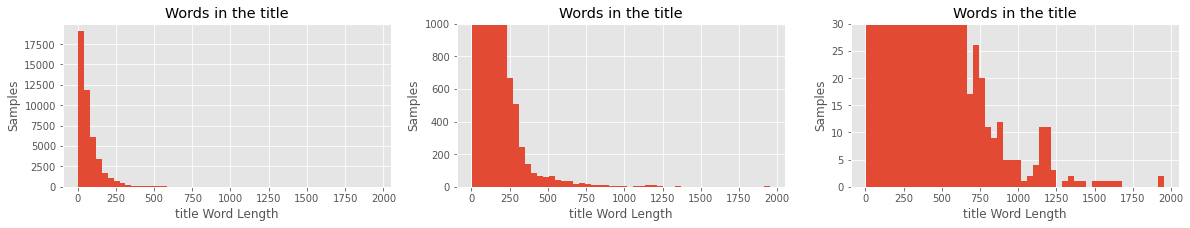

In [66]:
#calculate hte number of words
word_num=data['description'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('description Word Length')
axes[0].set_title('Words in the description')

axes[1].hist(word_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('description Word Length')
axes[1].set_title('Words in the description')

axes[2].hist(word_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('description Word Length')
axes[2].set_title('Words in the description')

Text(0.5, 1.0, 'Words in the title')

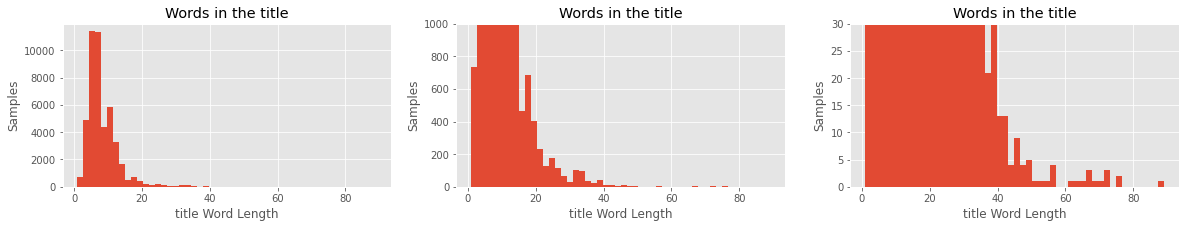

In [67]:
word_num_title=data['title'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('title Word Length')
axes[0].set_title('Words in the title')

axes[1].hist(word_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('title Word Length')
axes[1].set_title('Words in the title')

axes[2].hist(word_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('title Word Length')
axes[2].set_title('Words in the title')

##Self Preprocessing Text

This function filters the descriptions of the products

In [73]:
data = pd.read_csv('retail-products-classification/train.csv')
print(data['description'].dtype)
#to avoid the error 'float' object has no attribute 'lower'
data['description'] = data['description'].astype("str")
data['title'] = data['title'].astype("str")


object


In [74]:
def filter_description (text_data):
    # filter the data extract numbers and special characters
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890',
          lower=True, 
          split=' ',
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 500 Words of the description
    del data_words[500:]
    return data_words   

In [23]:
text_data =data['description'].iloc[27]
# filter the data extract numbers and special characters
data_words = tf.keras.preprocessing.text.text_to_word_sequence(
      text_data,
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890',
      lower=True, 
      split=' ',
    )
#filter short words with less then 2 characters
data_words = [i for i in data_words if(len(i) > 2)]
# Remove stop words
data_words = [s for s in data_words if s not in stop_english]
print(data_words)
print(data_words)
del data_words[3:]
print(data_words)

['buy', 'glominerals', 'concealers', 'correctors', 'glominerals', 'gloeye', 'revitalize']
['buy', 'glominerals', 'concealers', 'correctors', 'glominerals', 'gloeye', 'revitalize']
['buy', 'glominerals', 'concealers']


In [30]:
#create the same datatype
data_filtered = data
#filter every title and every text description
for i in range(0,data.shape[0]):
    data_filtered['description'].iloc[i] =filter_description(data['description'].iloc[i])
    data_filtered['title'].iloc[i] =filter_description(data['title'].iloc[i])

In [31]:
#here is an exmaple of how the text got filtered
print(data['description'].iloc[27])
print(data_filtered['description'].iloc[27])

['buy', 'glominerals', 'concealers', 'correctors', 'glominerals', 'gloeye', 'revitalize']
['buy', 'glominerals', 'concealers', 'correctors', 'glominerals', 'gloeye', 'revitalize']


In [205]:
data_filtered.head()

,ImgId,title,description,categories
0,B000HYL1V6,"[tungsten, solder, pick, handle]","[solder, pick, picking, molten, solder, making...","Arts, Crafts & Sewing"
1,B00006HXWY,"[write, right, screen, protector, sony]","[screen, need, protect, screens, expensive, li...",Cell Phones & Accessories
2,B000GAWSBS,"[casio, mens, dbc, databank, digital, watch, d...","[bringing, precision, glance, casio, men's, da...","Clothing, Shoes & Jewelry"
3,B000040JOL,"[factory, reconditioned, dewalt, heavy, duty, ...","[factory, reconditioned, dewalt, heavy, duty, ...",Tools & Home Improvement
4,B00006IB78,"[energizer, light]","[twoway, light, features, bright, flashlight, ...",Health & Personal Care


In [84]:
'!pip install transformers &> /dev/null
from transformers import BertTokenizer, BertModel

In [94]:
#download 
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = TFBertModel.from_pretrained("bert-large-uncased")

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [98]:
text = data['description'].iloc[1]
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)
output

Keyword arguments {'do_lower_case': 'True'} not recognized.


TFBaseModelOutputWithPooling([('last_hidden_state',
                               <tf.Tensor: shape=(1, 97, 1024), dtype=float32, numpy=
                               array([[[ 0.1703732 , -0.5543323 , -0.6868732 , ..., -0.52425605,
                                        -0.62810385,  0.5651812 ],
                                       [-0.09712867,  0.41305035, -0.52377224, ..., -0.06823797,
                                        -0.1296912 ,  0.22865738],
                                       [-0.41446644,  0.12517135, -0.37263435, ..., -0.18761733,
                                         0.2804073 ,  0.5830432 ],
                                       ...,
                                       [-0.29996824, -0.3098527 , -0.08791725, ..., -0.1529285 ,
                                         0.01663756, -0.00520547],
                                       [ 0.22667593,  0.2517398 , -0.41813874, ...,  0.28371453,
                                        -0.8828432 , -0.01458286]

## Image Analyse

In [72]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('retail-products-classification/train/train/*.jpg'): #assuming .jpg
    im=Image.open(filename)
    image_list.append(im)


KeyboardInterrupt: ignored

In [ ]:
j = 1   # counter for loop iterations
rows = 3
columns = 6
stepsize = 42

fig = plt.subplots(rows, columns, figsize=(20,6))

# eventuell noch die jeweilige Kategorie als title
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image_list[i])
    j += 1

plt.tight_layout()
print('iterations: ', j-1)


Parameter setting for the Model to train

In [75]:
train_images_path = 'retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 5
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [76]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [77]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

## Text preprocessing

In [69]:
def get_token(description):
        # split the description into tokens (words)
        tokens1 = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens2 = [i for i in tokens1 if(len(i) > 2)]
        # Remove stop words
        tokens3 = [s for s in tokens2 if s not in stop_english]

        #remove
        return tokens

## Normalize the image

In [78]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

## Read Data
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category. 

In [79]:
corpus = []
images = []
labels = []
#get a list of all files in the directory
files = os.listdir(train_images_path)
random.shuffle(files)

#iterate trough every single image in the list files
for img in files:
    #get the id of the image by removing the .jpeg
    img_id = img.split('.')[0]
    #create the image(size 80x80, rgb, convert into array)
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            #read the data of the image in the row with the image id
            index = data[data['ImgId']==img_id].index.values[0]
            #write the data into row
            row = data.iloc[index , :]
            #family = category of the image
            family = row[3]
            #if the family of the products is in the define categories
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                #adds an item to the end of the list images
                images.append(img_array.astype('float32'))
                #get a list with all tokens (words) in the description and title
                token_list = filter_description(str(title) + ' ' + str(description))#changed
                #adds the words of the current token_list to the corpus (Textsammlung)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

#converting
images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [80]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

In [ ]:
'!pip install transformers &> /dev/null
from transformers import BertTokenizer, BertModel, TFBertModel


In [ ]:
#download 
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = TFBertModel.from_pretrained("bert-large-uncased")
text = data['description'].iloc[1]
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)
output

## FastText pretrained vectors
[Download](https://fasttext.cc/docs/en/crawl-vectors.html) and load FastText pretrained vectors. Otherwise use the gensim to load the fasttext model. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. Then initilize the embedding matrix with fastText word vectors.

In [81]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)
        

[==================================================] 100.0% 958.5/958.4MB downloaded


  0%|          | 0/55095 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 55095/55095 [00:00<00:00, 202901.90it/s]


In [82]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

21217
33878


## Neural Network Model
Since our dataset contains both image and text, the model is capable to take both inputs together. For the image classification, we have used the MobileNet and LSTM network for the text classification. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build lightweight (17Mb) deep neural networks.
For the text classification, we have built a Keras sequential model which start with an embedding layer. The embedding layer holds individual vector for each word in the corpus. We have used fastText pre-trained English embedding to initialize each word by a 300-dimensional vector and loaded the pre-trained words embedding matrix into the embedding layer. After training the model, the words with semantically similar meaning often have similar vectors. Since the text classification model is a recurrent neural network, we added an LSTM layer followed by the embedding layer.

In [83]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(model.output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
model.summary()

Model: "mobilenet_1.00_None"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)

In [85]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense 
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           16528800  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
Total params: 16,635,240
Trainable params: 106,440
Non-trainable params: 16,528,800
_________________________________________________________________


## Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

In [86]:
merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [87]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 40, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 40, 40, 32)   0           conv1_bn[0][0]                   
______________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Split the data into 80% training and 20% test

In [88]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

In [89]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600, 40)


## Data Augumentation

In [90]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [91]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
final_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

## Train the model
During training on a supervised machine learning prediction task, the parameters of the neural network - the weights- are the embeddings will modify to minimize the loss.

In [92]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([image_train, text_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([image_test,text_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1050/1050 [==============================] - 136s 95ms/step - loss: 2.1219 - accuracy: 0.3284 - precision: 0.4381 - recall: 0.1124 - val_loss: 1.6238 - val_accuracy: 0.4858 - val_precision: 0.5632 - val_recall: 0.2701
Epoch 2/5
1050/1050 [==============================] - 93s 89ms/step - loss: 1.5595 - accuracy: 0.5026 - precision: 0.5794 - recall: 0.3330 - val_loss: 1.5297 - val_accuracy: 0.5149 - val_precision: 0.5885 - val_recall: 0.3779
Epoch 3/5
1050/1050 [==============================] - 95s 91ms/step - loss: 1.4051 - accuracy: 0.5542 - precision: 0.5969 - recall: 0.4105 - val_loss: 1.2801 - val_accuracy: 0.5914 - val_precision: 0.6116 - val_recall: 0.4243
Epoch 4/5
1050/1050 [==============================] - 96s 91ms/step - loss: 1.3103 - accuracy: 0.5812 - precision: 0.6234 - recall: 0.4326 - val_loss: 1.2792 - val_accuracy: 0.5887 - val_precision: 0.6315 - val_recall: 0.4374
Epoch 5/5
1050/1050 [==============================] - 95s 91ms/step - loss: 1.2339 - accuracy: 0.603

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

 # **Make predictions on validation data**

In [93]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 108s


In [94]:
accuracy_score(y_test, classes)

0.6335714285714286

In [95]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,classes)

Text(0.5, 114.0, 'Predicted label')

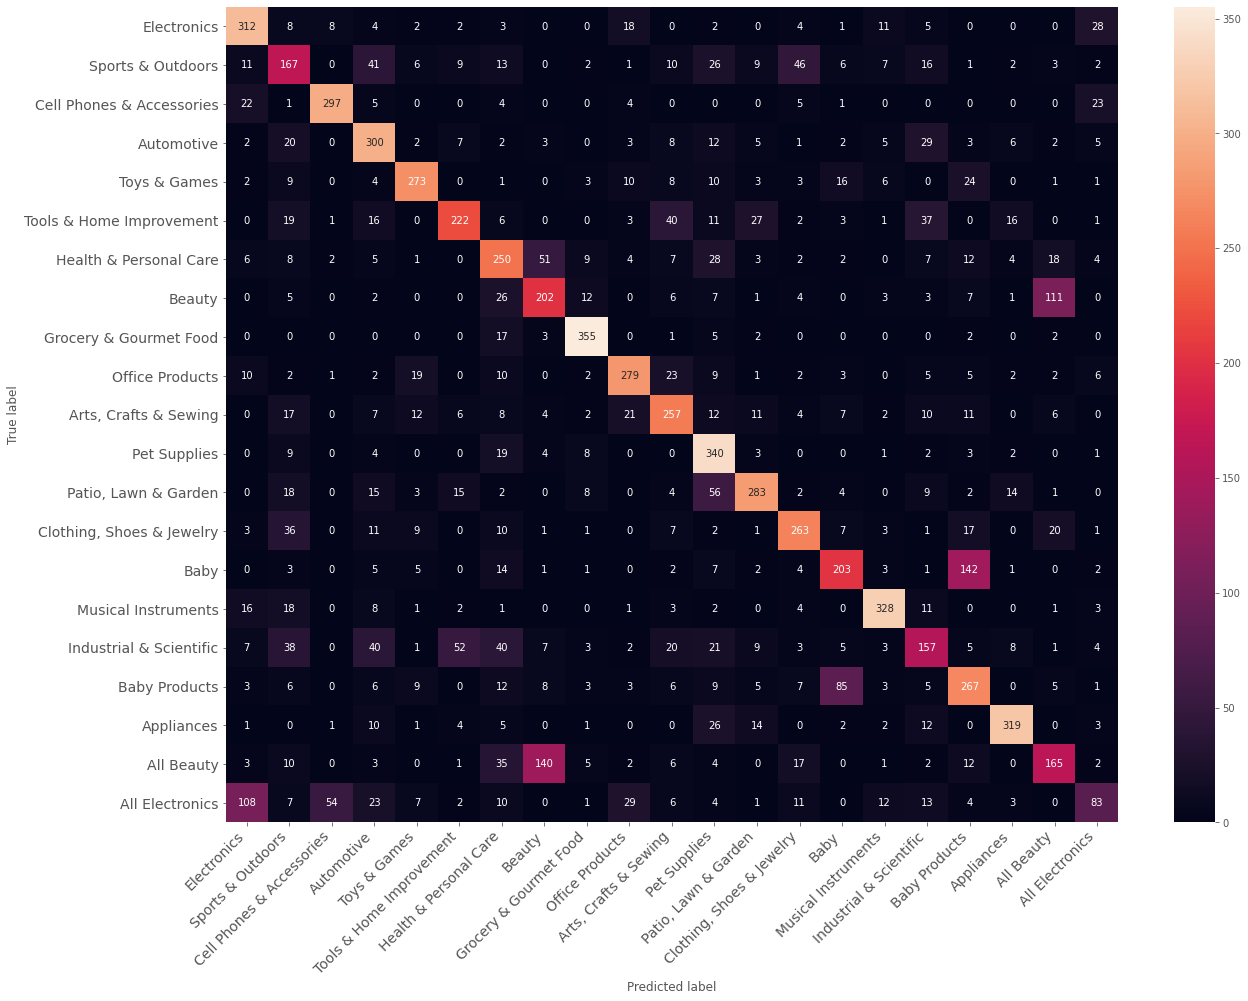

In [96]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

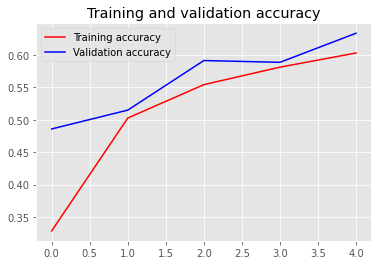

<Figure size 432x288 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

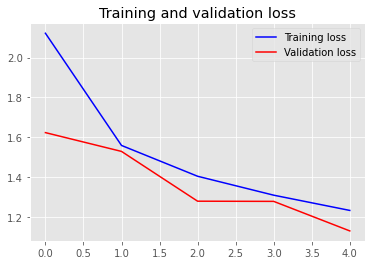

In [98]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Extract and visualize embedding

In [99]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

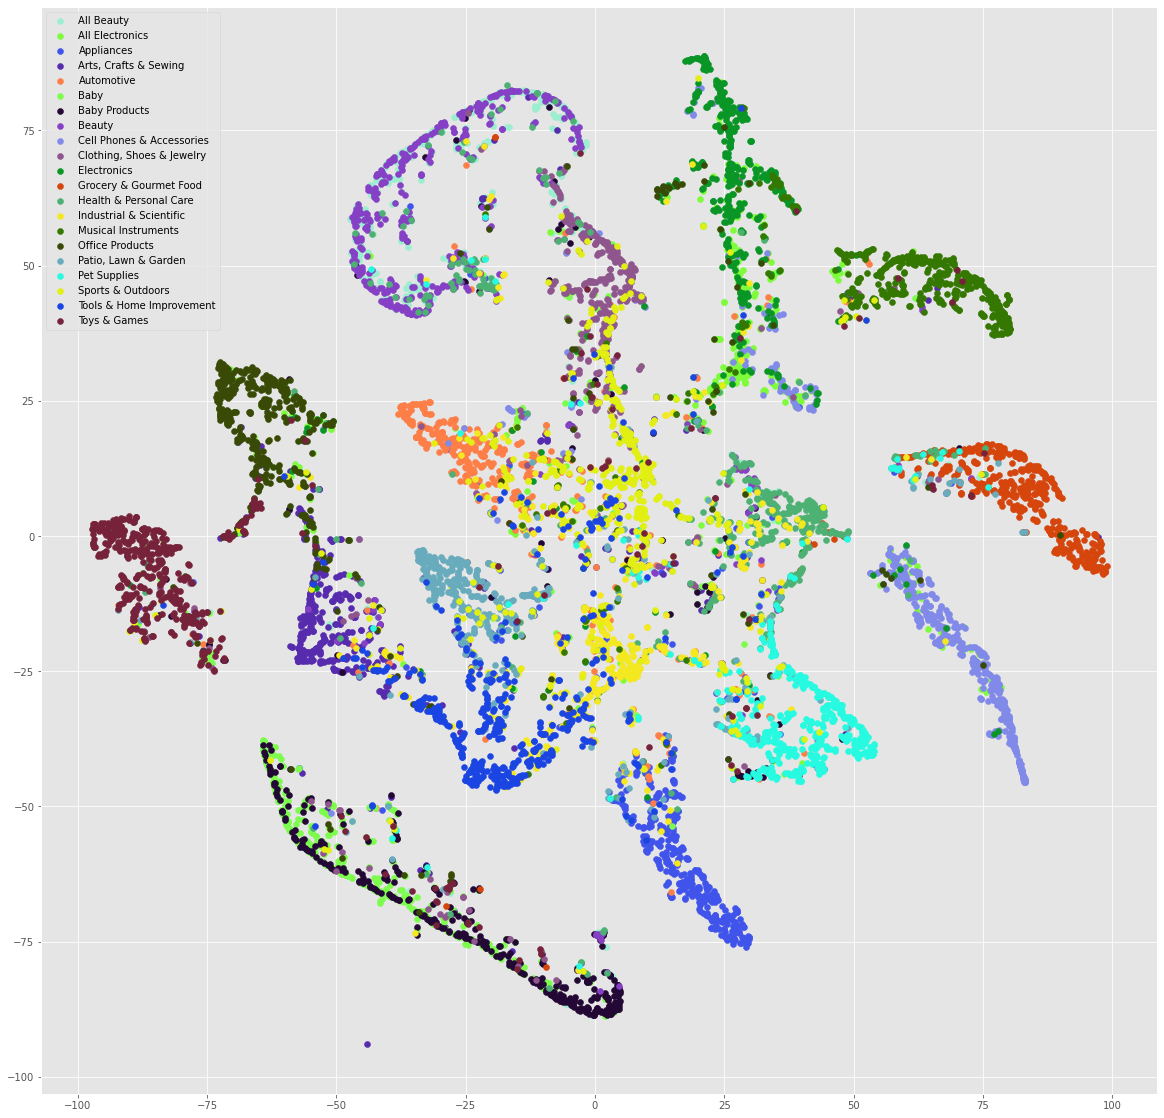

In [101]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

# Read the test data

In [102]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [103]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [104]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [105]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [106]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

# **Make predictions on test data**

In [107]:
pred = final_model.predict([test_images, test_pad],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 82s


# Create submission file

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])